In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats
import statsmodels.api as sm
import os 
import numpy as np

In [104]:
#function to read multiple csv files in a directorty and load them into one single dataframe
def load_csv_files(directory):
    data_frames = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            try:
                df = pd.read_csv(file_path, on_bad_lines='skip')  #avoid errors while reading 
                data_frames.append(df)
            except pd.errors.ParserError as e:
                print(f"Error reading {file_path}: {e}")
    return pd.concat(data_frames, ignore_index=True)



In [105]:
submissions_cleaned_df= load_csv_files('submissions_cleaned')
comments_cleaned_df = load_csv_files('comments_cleaned/comms')
submissions_linked_df = load_csv_files('comments_cleaned/subs')

/home/gli/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


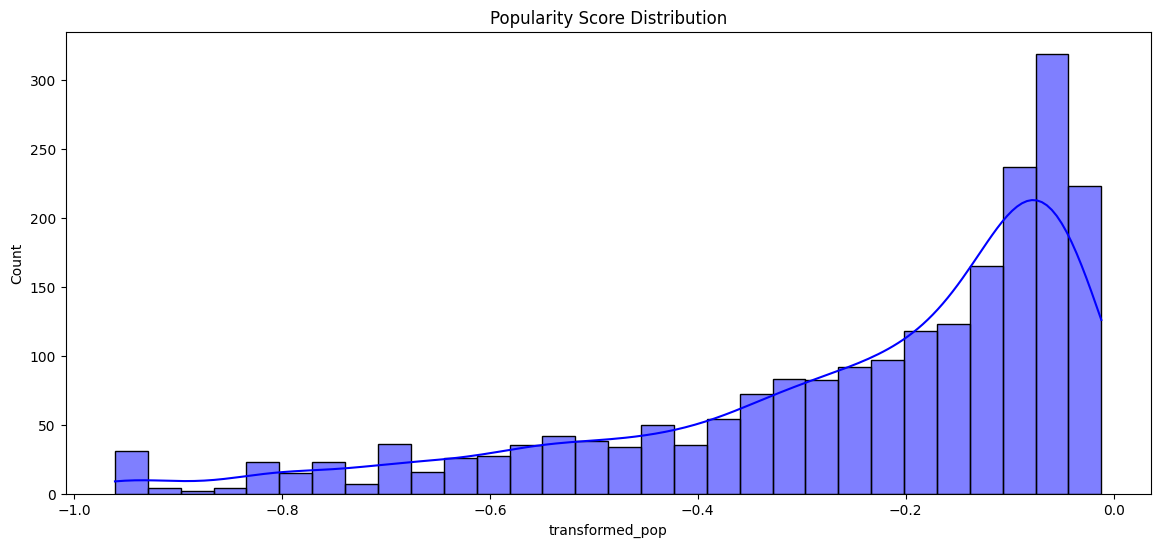

In [106]:
#histograms of popularity scores 

plt.figure(figsize=(14, 6))
submissions_cleaned_df['transformed_pop'] = np.log(submissions_cleaned_df['pop_score'])

sns.histplot(submissions_cleaned_df['transformed_pop'], bins=30, kde=True, color='blue')

plt.title('Popularity Score Distribution')
plt.show()

In [107]:
# POPULARITY OF POSITIVE AND NEGATIVE SUBMISSIONS

positive_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] >= 0.25]['pop_score']
neutral_submissions= (submissions_cleaned_df['sentiment_score'] > -0.25) & (submissions_cleaned_df['sentiment_score'] < 0.25)
neutral_popularity = submissions_cleaned_df.loc[neutral_submissions, 'pop_score']
negative_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] <=-0.25 ]['pop_score']

#we can assume normally distributed data based on the number of samples here 

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("The p value for T-test is: ")
print(stats.ttest_ind(positive_popularity, negative_popularity).pvalue)
print("\nAverage popularity for POSITIVE posts: ")
print(positive_popularity.mean())
print("\nAverage popularity for NEGATIVE posts: ")
print(negative_popularity.mean())

Number of positive samples: 831
Number of neutral samples: 877
Number of negative samples: 734



The p value for T-test is: 
0.00022733233444668425

Average popularity for POSITIVE posts: 
0.7130306194223825

Average popularity for NEGATIVE posts: 
0.7643049800681199


In [108]:
# POPULARITY OF POSITIVE, NEUTRAL AND NEGATIVE SUBMISSIONS

print("The p value for ANOVA test is: ")
print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)
print("\n")

df_positive = pd.DataFrame({'pop_score': positive_popularity, 'sentiment_group': 'Positive'})
df_neutral = pd.DataFrame({'pop_score': neutral_popularity, 'sentiment_group': 'Neutral'})
df_negative = pd.DataFrame({'pop_score': negative_popularity, 'sentiment_group': 'Negative'})

#join all the dataframes along with the sentiment group
combined_df = pd.concat([df_positive, df_neutral, df_negative])

tukey = pairwise_tukeyhsd(combined_df['pop_score'], groups=combined_df['sentiment_group'])
print(tukey)

The p value for ANOVA test is: 
1.739570396830356e-23


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
Negative  Neutral  -0.1522    0.0 -0.1877 -0.1167   True
Negative Positive  -0.0513 0.0024 -0.0872 -0.0153   True
 Neutral Positive   0.1009    0.0  0.0666  0.1353   True
--------------------------------------------------------


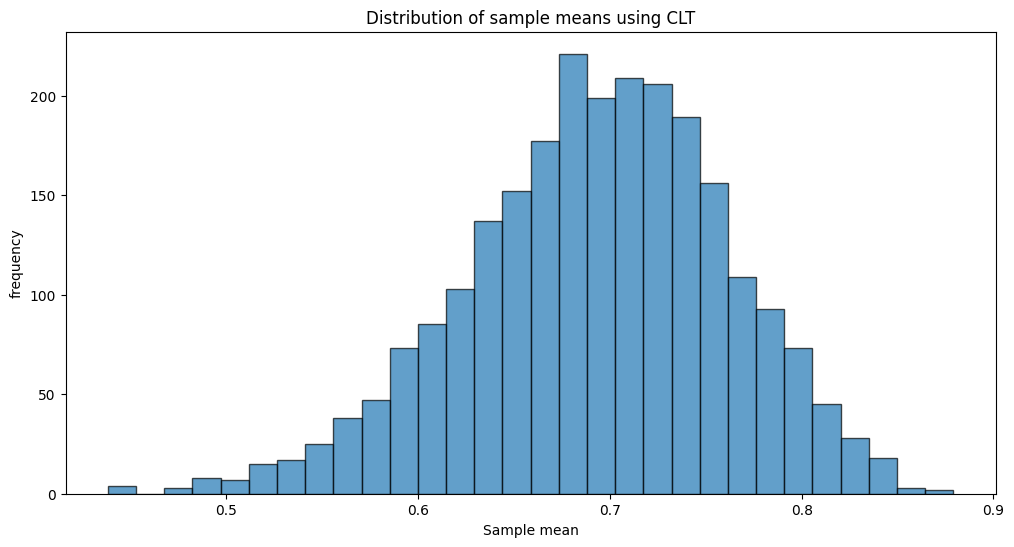

In [109]:
#apply CLT to the pop_score column to hopefully get a more normal distribution of pop_scores

sample_size = 20 
num_samples = submissions_cleaned_df.shape[0]

def applyCLT(data, sample_size, num_samples):
    sample_means = []
    for _ in range(num_samples):  #iterate through the number of samples you want to take 
        sample = data.sample(n=sample_size, replace=True) #take a sample of size smaple_size 
        sample_means.append(sample.mean())   #add the mean of that sample top the sample_means list 
    return sample_means


sample_means = applyCLT(submissions_cleaned_df['pop_score'], sample_size, num_samples)
submissions_cleaned_df['pop_score_CLT'] = sample_means

plt.figure(figsize=(12, 6))
plt.hist(sample_means, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of sample means using CLT')
plt.xlabel('Sample mean')
plt.ylabel('frequency')
plt.show()
#result: more normal looking !

In [110]:
# POPULARITY OF POSITIVE, NEUTRAL AND NEGATIVE SUBMISSIONS AFTER CLT

positive_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] >= 0.25]['pop_score_CLT']
neutral_submissions = (submissions_cleaned_df['sentiment_score'] > -0.25) & (submissions_cleaned_df['sentiment_score'] < 0.25)
neutral_popularity = submissions_cleaned_df.loc[neutral_submissions, 'pop_score_CLT']
negative_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] <=-0.25 ]['pop_score_CLT']

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)
#slightly better but not that much better than the popularity score based on the upvotes-downvotes(they are essentially the same)


Number of positive samples: 831
Number of neutral samples: 877
Number of negative samples: 734



Result of ANOVA test: 

 The p value is: 
0.8665972061966589


In [111]:
# SENTIMENT OF SUBMISSIONS ACROSS DIFF SUBREDDITS

subreddit_groups = [submissions_cleaned_df[submissions_cleaned_df['subreddit'] == sub]['sentiment_score']
                     for sub in submissions_cleaned_df['subreddit'].unique()]
print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(*subreddit_groups).pvalue)  
print("\n")

# we got significance! do post-hoc analysis with tukey
sentiment_subreddit_melted = pd.melt(
    submissions_cleaned_df[['subreddit', 'sentiment_score']], id_vars=["subreddit"], value_vars=["sentiment_score"]
)
print(pairwise_tukeyhsd(sentiment_subreddit_melted['value'], sentiment_subreddit_melted['subreddit'], alpha = 0.05))

Result of ANOVA test: 

 The p value is: 
0.002029423623111514


     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
   antiwork aznidentity    0.113 0.0125  0.0163  0.2096   True
   antiwork programming   0.0816 0.1542 -0.0164  0.1796  False
   antiwork     science   0.0436 0.7343 -0.0532  0.1405  False
   antiwork  technology  -0.0065 0.9998 -0.1031  0.0902  False
aznidentity programming  -0.0314 0.9046 -0.1289  0.0661  False
aznidentity     science  -0.0693  0.284 -0.1657   0.027  False
aznidentity  technology  -0.1194 0.0064 -0.2156 -0.0232   True
programming     science  -0.0379 0.8271 -0.1357  0.0598  False
programming  technology   -0.088 0.0995 -0.1856  0.0095  False
    science  technology  -0.0501 0.6163 -0.1465  0.0464  False
--------------------------------------------------------------


In [112]:
# SENTIMENT OF SUBMISSIONS ACROSS DIFF COMMENT COUNTS

bins = [0, 3, 10, 20, 50, 100, 500, 1000, submissions_cleaned_df['num_comments'].max()] #max for this dataframe is ~4800
labels = ['0-3', '4-10', '11-20','21-50', '51-100', '101-500','501-1000', '1001+']
submissions_cleaned_df['comment_bin'] = pd.cut(submissions_cleaned_df['num_comments'], bins=bins, labels=labels)

#for each bin in the labels, filter the datframe to include the rows where comment_bin = bin label
comment_bins = [submissions_cleaned_df[submissions_cleaned_df['comment_bin'] == bin]['sentiment_score'] # then get the sentiment score 
                for bin in labels]

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(*comment_bins).pvalue)

Result of ANOVA test: 

 The p value is: 
0.24567970418690477


In [113]:
# IMPACT OF SENTIMENT OF COMMENT ON POPULARITY OF COMMENT

comments_cleaned_df['score'] = pd.to_numeric(comments_cleaned_df['score'], errors='coerce')

comments_cleaned_df = comments_cleaned_df.dropna(subset=['score', 'sentiment_score'])
y = comments_cleaned_df[['score']].astype(float)
X = comments_cleaned_df['sentiment_score'].astype(float)
X = sm.add_constant(X)
X=X.dropna()
y=y.dropna()
model = sm.OLS(y, X).fit()
print(model.summary())
print(model.pvalues)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4559
Date:                Fri, 02 Aug 2024   Prob (F-statistic):              0.500
Time:                        17:22:18   Log-Likelihood:                -15841.
No. Observations:                2318   AIC:                         3.169e+04
Df Residuals:                    2316   BIC:                         3.170e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              27.5332      4.670     

In [114]:
#make sure all scores are numeric to avoid type errors and drop the non-numeric rows 
submissions_cleaned_df['sentiment_score'] = pd.to_numeric(submissions_cleaned_df['sentiment_score'], errors='coerce')

submissions_cleaned_df = submissions_cleaned_df.dropna(subset=['sentiment_score', 'time_created'])

#pd.cut sorts the sentiment scores into bins to represent negative, positive and neutral comments 
submissions_cleaned_df['sentiment_category'] = pd.cut(submissions_cleaned_df['sentiment_score'],
                                                      bins=[-float('inf'), -0.25, 0.25, float('inf')],
                                                      labels=['Negative', 'Neutral', 'Positive'])

#groupby hour and sentiment, then count the number of submissions under each group 
submission_counts = submissions_cleaned_df.groupby(['time_created', 'sentiment_category'], observed=True).size().unstack(fill_value=0)

positive_submissions = submission_counts['Positive']
neutral_submissions = submission_counts['Neutral']
negative_submissions = submission_counts['Negative']

print("Result of ANOVA test:\n\nThe p-value is:")
print(stats.f_oneway(positive_submissions, neutral_submissions, negative_submissions).pvalue)


Result of ANOVA test:

The p-value is:
0.0013157916783778187


In [115]:
submissions_cleaned_df['time_created'] = pd.to_datetime(submissions_cleaned_df['time_created'], errors='coerce')
submissions_cleaned_df['hour_of_day'] = submissions_cleaned_df['time_created'].dt.hour #get the hour each post was created 

#group by hour of the day and setniment, then count the submissions under each group 
hourly_counts = submissions_cleaned_df.groupby(['hour_of_day'], observed=True).size().reset_index(name='count')
hourly_sentiment_counts = submissions_cleaned_df.groupby(['hour_of_day', 'sentiment_category'], observed=True).size().reset_index(name='count')

print(hourly_sentiment_counts)


    hour_of_day sentiment_category  count
0             0           Negative     23
1             0            Neutral     22
2             0           Positive     13
3             1           Negative     11
4             1            Neutral     23
..          ...                ...    ...
67           22            Neutral     21
68           22           Positive     24
69           23           Negative     11
70           23            Neutral     26
71           23           Positive     21

[72 rows x 3 columns]


/tmp/ipykernel_12432/2086108170.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  submissions_cleaned_df['time_created'] = pd.to_datetime(submissions_cleaned_df['time_created'], errors='coerce')


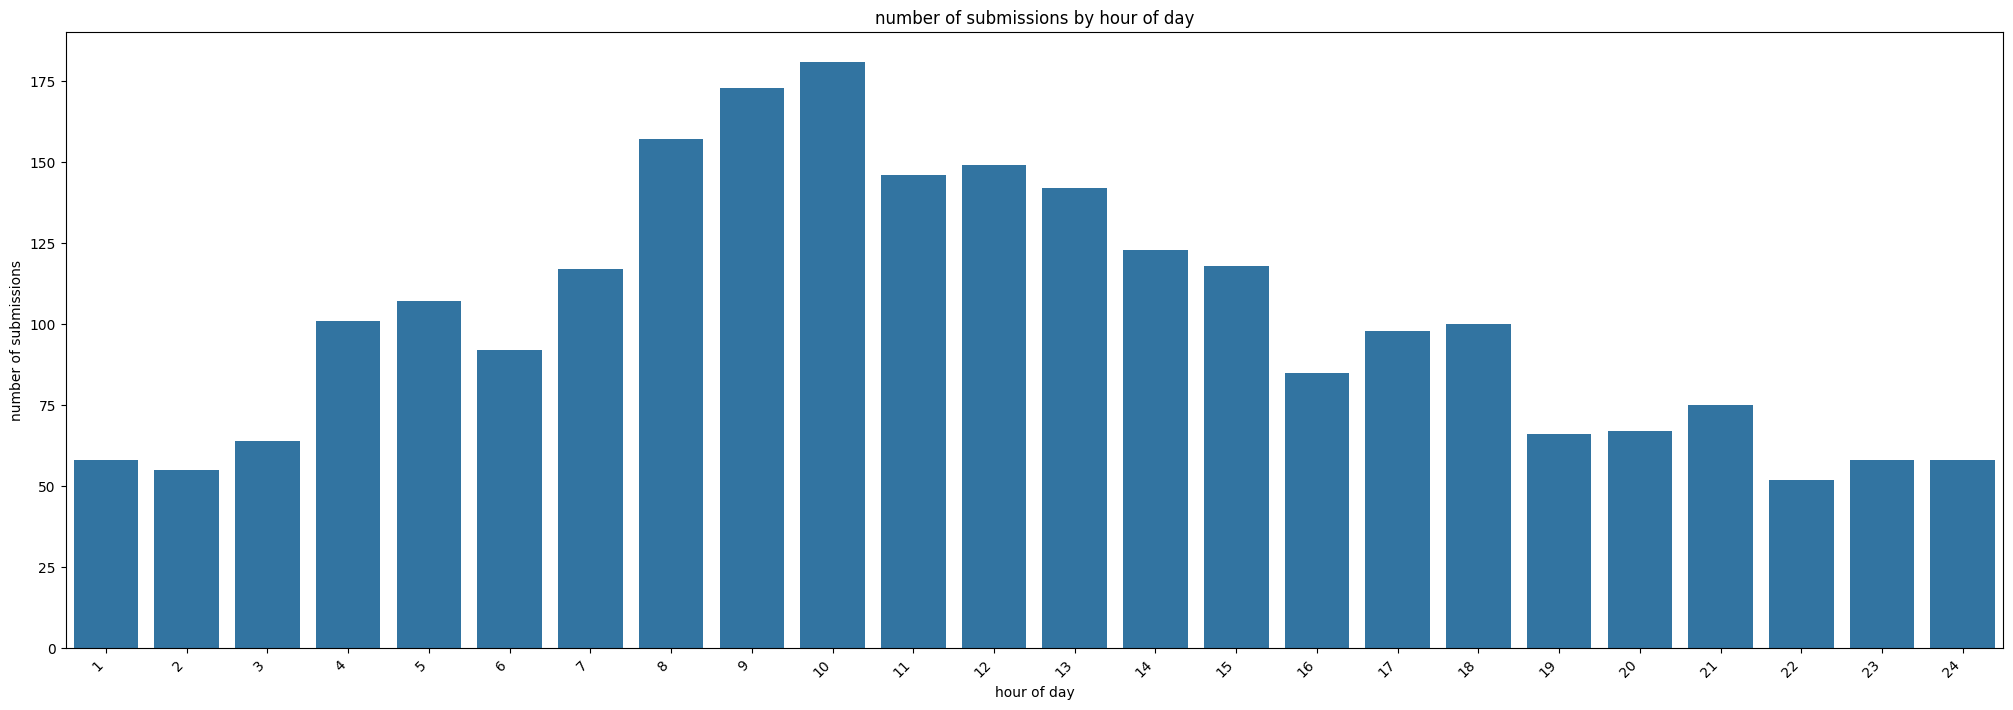

In [116]:
#visualize number of submissions at each hour of the day 
plt.figure(figsize=(25, 8))
sns.barplot(data=hourly_counts, x='hour_of_day', y='count')
plt.title('number of submissions by hour of day')
plt.xlabel('hour of day')
plt.ylabel('number of submissions')
plt.xticks(ticks=range(24), labels=range(1, 25))
plt.xticks(rotation=45, ha='right')
plt.show()

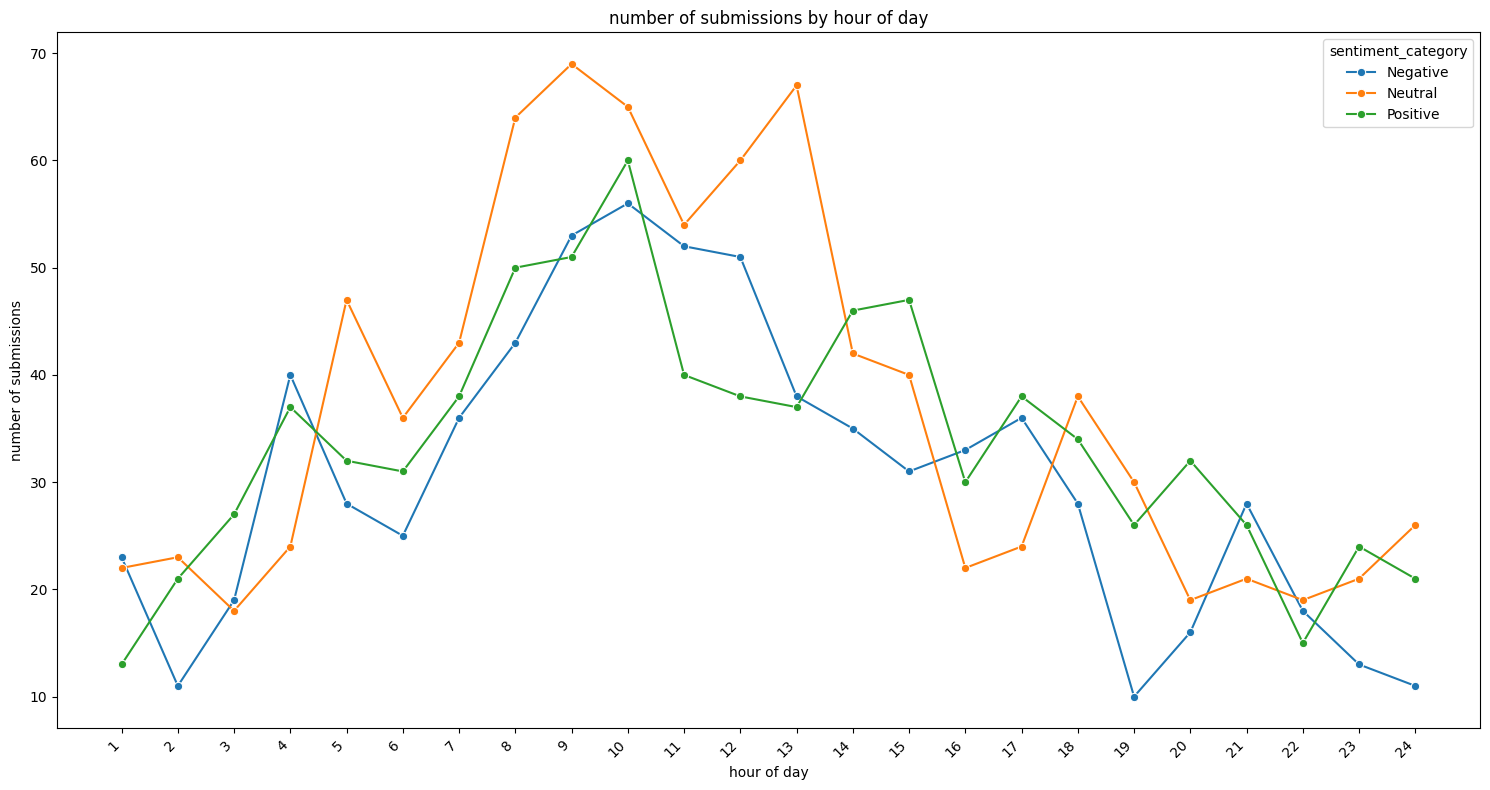

In [117]:
#using a line graph, maybe we can get rid of this? doesnt really add much and I cant figure out how to resolve the wanrings...
hourly_sentiment_counts.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
plt.figure(figsize=(15, 8))
sns.lineplot(data=hourly_sentiment_counts, x='hour_of_day', y='count', hue='sentiment_category', marker='o')
plt.title('number of submissions by hour of day')
plt.xlabel('hour of day')
plt.ylabel('number of submissions')
plt.xticks(ticks=range(24), labels=range(1, 25))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [118]:
# IMPACT OF HOUR OF DAY ON SENTIMENT

contingency_table = pd.pivot_table(hourly_sentiment_counts, values='hour_of_day', index='hour_of_day', columns='sentiment_category', fill_value=0)
print("Chi-square test result:")
print(stats.chi2_contingency(contingency_table).pvalue)

Chi-square test result:
0.005056729180256783


/tmp/ipykernel_12432/2550598502.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  contingency_table = pd.pivot_table(hourly_sentiment_counts, values='hour_of_day', index='hour_of_day', columns='sentiment_category', fill_value=0)


In [119]:
# WHEN ARE NEGATIVE POSTS POPULAR? (DAY / NIGHT)
submissions_cleaned_df['time_of_day'] = submissions_cleaned_df['hour_of_day'].apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')

negative_comments = submissions_cleaned_df[submissions_cleaned_df['sentiment_category'] == 'Negative']

negative_grouped = negative_comments.groupby('time_of_day').size().reset_index(name='count')

negative_day = negative_comments[negative_comments['time_of_day'] == 'Day']
negative_night = negative_comments[negative_comments['time_of_day'] == 'Night']

print("t-test results on negative submissions popularity : ")
print(stats.ttest_ind(negative_day['pop_score'], negative_night['pop_score'], equal_var=False).pvalue)

t-test results on negative submissions popularity : 
0.6903357344685068


In [120]:
# WHEN ARE POSITIVE POSTS POPULAR? (DAY / NIGHT)
positive_comments = submissions_cleaned_df[submissions_cleaned_df['sentiment_category'] == 'Positive']

positive_grouped = positive_comments.groupby('time_of_day').size().reset_index(name='count')

positive_day = positive_comments[positive_comments['time_of_day'] == 'Day']
positive_night = positive_comments[positive_comments['time_of_day'] == 'Night']

print("t-test results on positive submissions popularity : ")
print(stats.ttest_ind(positive_day['pop_score'], positive_night['pop_score'], equal_var=False).pvalue)

t-test results on positive submissions popularity : 
0.5688319641662898


In [121]:
# POST POPULARITY DURING NIGHT
avg_popularity_pos = positive_night['pop_score'].mean()
avg_popularity_neg = negative_night['pop_score'].mean()

print("avg pop_score for positive submissions during the night:", avg_popularity_pos)
print("avg pop_score for negative submissions during the night:", avg_popularity_neg)

print("t-test results on positive vs negative submissinos at night popularity : ")
print(stats.ttest_ind(positive_night['pop_score'], negative_night['pop_score'], equal_var=False).pvalue)

avg pop_score for positive submissions during the night: 0.7052262518360656
avg pop_score for negative submissions during the night: 0.7588883781404958
t-test results on positive vs negative submissinos at night popularity : 
0.025453493720247043


In [122]:
# POST POPULARITY DURING DAY
avg_popularity_pos = positive_day['pop_score'].mean()
avg_popularity_neg = negative_day['pop_score'].mean()

print("avg pop_score for positive submissions during the day:", avg_popularity_pos)
print("avg pop_score for negative submissions during the day:", avg_popularity_neg)

print("t-test results on positive vs negative submissinos at night popularity : ")
print(stats.ttest_ind(positive_day['pop_score'], negative_day['pop_score'], equal_var=False).pvalue)

avg pop_score for positive submissions during the day: 0.7173634781925343
avg pop_score for negative submissions during the day: 0.7669692436178862
t-test results on positive vs negative submissinos at night popularity : 
0.003698138091861163


In [136]:
# IMPACT OF TIME OF DAY + SENTIMENT ON SENTIMENT

#get the relevant column for submissions_cleaned_df and put it in 'df',less typos

submissions_cleaned_df['time_of_day'] = submissions_cleaned_df['time_of_day'].astype(str)
submissions_cleaned_df['sentiment_category'] = submissions_cleaned_df['sentiment_category'].astype(str)
df = submissions_cleaned_df[['time_of_day', 'sentiment_category', 'sentiment_score', 'pop_score']]

f_stat, p_value = stats.f_oneway(
    df[(df['time_of_day'] == 'Day') & (df['sentiment_category'] == 'Negative')]['sentiment_score'],
    df[(df['time_of_day'] == 'Day') & (df['sentiment_category'] == 'Neutral')]['sentiment_score'],
    df[(df['time_of_day'] == 'Day') & (df['sentiment_category'] == 'Positive')]['sentiment_score'],
    df[(df['time_of_day'] == 'Night') & (df['sentiment_category'] == 'Negative')]['sentiment_score'],
    df[(df['time_of_day'] == 'Night') & (df['sentiment_category'] == 'Neutral')]['sentiment_score'],
    df[(df['time_of_day'] == 'Night') & (df['sentiment_category'] == 'Positive')]['sentiment_score']
)

print(f"ANOVA F-statistic: {f_stat}")
print(f"ANOVA p-value: {p_value}")

if p_value < 0.05:
    print("there is a sigificant difference in sentiment scores during different times of day.. performing Tukey test... \n")
    
    #creates a group for each time of day and sentiment category, like Day_Positive 
    df['group'] = df['time_of_day'] + '_' + df['sentiment_category']
    #df.loc[:, 'group'] = df['time_of_day'] + '_' + df['sentiment_category']

    tukey = pairwise_tukeyhsd(df['sentiment_score'], groups=df['group'])
    print("\nTukey HSD results:\n")
    print(tukey)

ANOVA F-statistic: 3423.8708877920776
ANOVA p-value: 0.0
there is a sigificant difference in sentiment scores during different times of day.. performing Tukey test... 



/tmp/ipykernel_12432/2332867482.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['time_of_day'] + '_' + df['sentiment_category']



Tukey HSD results:

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
  Day_Negative    Day_Neutral   0.6579    0.0  0.6237  0.6922   True
  Day_Negative   Day_Positive   1.3033    0.0  1.2679  1.3388   True
  Day_Negative Night_Negative   0.0147 0.9328 -0.0293  0.0587  False
  Day_Negative  Night_Neutral   0.6695    0.0  0.6287  0.7104   True
  Day_Negative Night_Positive   1.3313    0.0  1.2904  1.3722   True
   Day_Neutral   Day_Positive   0.6454    0.0  0.6114  0.6793   True
   Day_Neutral Night_Negative  -0.6432    0.0 -0.6861 -0.6004   True
   Day_Neutral  Night_Neutral   0.0116 0.9604 -0.0279  0.0512  False
   Day_Neutral Night_Positive   0.6734    0.0  0.6338   0.713   True
  Day_Positive Night_Negative  -1.2886    0.0 -1.3324 -1.2448   True
  Day_Positive  Night_Neutral  -0.6338    0.0 -0.6743 -0.5932   True
  Day_Positiv

In [137]:
# IMPACT OF TIME OF DAY + SENTIMENT ON POPULARITY

f_stat, p_value = stats.f_oneway(
    df[(df['time_of_day'] == 'Day') & (df['sentiment_category'] == 'Negative')]['pop_score'],
    df[(df['time_of_day'] == 'Day') & (df['sentiment_category'] == 'Neutral')]['pop_score'],
    df[(df['time_of_day'] == 'Day') & (df['sentiment_category'] == 'Positive')]['pop_score'],
    df[(df['time_of_day'] == 'Night') & (df['sentiment_category'] == 'Negative')]['pop_score'],
    df[(df['time_of_day'] == 'Night') & (df['sentiment_category'] == 'Neutral')]['pop_score'],
    df[(df['time_of_day'] == 'Night') & (df['sentiment_category'] == 'Positive')]['pop_score']
)

print(f"ANOVA F-statistic: {f_stat}")
print(f"ANOVA p-value: {p_value}")

if p_value < 0.05:
    print("there is a sigificant difference in pop scores during different times of day.. performing Tukey test... \n")
    
    #creates a group for each time of day and sentiment category, like Day_Positive 
    df['group'] = df['time_of_day'] + '_' + df['sentiment_category']
    #df.loc[:, 'group'] = df['time_of_day'] + '_' + df['sentiment_category']

    tukey = pairwise_tukeyhsd(df['pop_score'], groups=df['group'])
    print("\nTukey HSD results:\n")
    print(tukey)

    print(stats.ttest_ind(df[df['time_of_day'] == 'Day']['pop_score'], df[df['time_of_day'] == 'Night']['pop_score']))

ANOVA F-statistic: 21.865757887139363
ANOVA p-value: 1.7527299460588817e-21
there is a sigificant difference in pop scores during different times of day.. performing Tukey test... 



/tmp/ipykernel_12432/659065340.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['time_of_day'] + '_' + df['sentiment_category']



Tukey HSD results:

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
  Day_Negative    Day_Neutral   -0.138    0.0 -0.1907 -0.0853   True
  Day_Negative   Day_Positive  -0.0496 0.0992 -0.1042  0.0049  False
  Day_Negative Night_Negative  -0.0081 0.9994 -0.0758  0.0597  False
  Day_Negative  Night_Neutral  -0.1811    0.0 -0.2439 -0.1182   True
  Day_Negative Night_Positive  -0.0617 0.0578 -0.1246  0.0011  False
   Day_Neutral   Day_Positive   0.0884    0.0  0.0362  0.1406   True
   Day_Neutral Night_Negative   0.1299    0.0   0.064  0.1958   True
   Day_Neutral  Night_Neutral  -0.0431 0.3319 -0.1039  0.0178  False
   Day_Neutral Night_Positive   0.0763 0.0049  0.0154  0.1371   True
  Day_Positive Night_Negative   0.0415 0.4936 -0.0259  0.1089  False
  Day_Positive  Night_Neutral  -0.1314    0.0 -0.1939  -0.069   True
  Day_Positiv

In [138]:
# print average scores for sentiment and popularity across sentiment and time of day
print(df[["group", "sentiment_score", "pop_score"]].groupby("group").mean())

                sentiment_score  pop_score
group                                     
Day_Negative          -0.655800   0.766969
Day_Neutral            0.002133   0.628968
Day_Positive           0.647510   0.717363
Night_Negative        -0.641103   0.758888
Night_Neutral          0.013749   0.585916
Night_Positive         0.675507   0.705226


In [22]:
#the pop_score ranges from 0-1, so we can split it into 3 categories:
    # low: 0-0.33
    # medium : 0.33-0.66
    # high : 0.66 - 1 

bins = [0, 0.33, 0.66, 1] 
labels = ['low popularity ', 'medium popularity', 'high popularity']

submissions_cleaned_df['pop_category'] = pd.cut(submissions_cleaned_df['pop_score'], bins=bins, labels=labels)

contingency_table = pd.crosstab(submissions_cleaned_df['controversial'], submissions_cleaned_df['pop_category'])

print("Chi-square test result:")
print(stats.chi2_contingency(contingency_table).pvalue)

Chi-square test result:
1.5559942321444934e-269


In [23]:
#further analysis to examine the relationship between the popularity and controversiality of a post
X = submissions_cleaned_df[['pop_score']]
X = sm.add_constant(X)  
y = submissions_cleaned_df['controversial']
modelLinear = sm.OLS(y, X)
modelLogistic = sm.Logit(y, X) #better suited for this experiment because it deals with binary or boolean values
resultLinear = modelLinear.fit()
resultLogistic = modelLogistic.fit()
print("\nLinear regression results: \n")
print(resultLinear.summary())
print("\nLogistic regression results: \n")
print(resultLogistic.summary())

Optimization terminated successfully.
         Current function value: 0.139341
         Iterations 10

Linear regression results: 

                            OLS Regression Results                            
Dep. Variable:          controversial   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     4054.
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:39:04   Log-Likelihood:                -471.14
No. Observations:                2442   AIC:                             946.3
Df Residuals:                    2440   BIC:                             957.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

In [24]:
#the sentiment_score ranges from -1-1, so we can split it into 3 categories:
    # negative: -1 - -0.25
    # neutral : -0.25 - 0.25 
    # positive : 0.25 - 1 
bins = [-1, -0.25, 0.25, 1] 
labels = ['Negative', 'Neutral', 'Positive']

submissions_cleaned_df['sentiment_category'] = pd.cut(submissions_cleaned_df['sentiment_score'], bins=bins, labels=labels)

contingency_table = pd.crosstab(submissions_cleaned_df['controversial'], submissions_cleaned_df['sentiment_category'])

chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(contingency_table)

print("Chi-square test result:")
print(stats.chi2_contingency(contingency_table).pvalue)

sentiment_category  Negative  Neutral  Positive
controversial                                  
False                    544      481       548
True                     190      413       266
Chi-square test result:
1.8605006861523055e-17


In [25]:
#further analysis to examine the effect of sentiment_score on the cahnes of a post being controversial 
X = submissions_cleaned_df[['sentiment_score']]
X = sm.add_constant(X)  
y = submissions_cleaned_df['controversial']
modelLinear = sm.OLS(y, X)
modelLogistic = sm.Logit(y, X) #better suited for this experiment because it deals with binary or boolean values
resultLinear = modelLinear.fit()
resultLogistic = modelLogistic.fit()
print("\nLinear regression results: \n")
print(resultLinear.summary())
print("\nLogistic regression results: \n")
print(resultLogistic.summary())

Optimization terminated successfully.
         Current function value: 0.649623
         Iterations 4

Linear regression results: 

                            OLS Regression Results                            
Dep. Variable:          controversial   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.711
Date:                Fri, 02 Aug 2024   Prob (F-statistic):            0.00964
Time:                        14:39:04   Log-Likelihood:                -1663.1
No. Observations:                2442   AIC:                             3330.
Df Residuals:                    2440   BIC:                             3342.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0

In [26]:
df = submissions_cleaned_df

controversial_scores = df[df['controversial'] == True]['sentiment_score']
non_controversial_scores = df[df['controversial'] == False]['sentiment_score']

print("Mean sentiment of controversial posts =",controversial_scores.mean())
print("Mean sentiment score of non-controversial posts = ",non_controversial_scores.mean())

print(f"Mann-Whitney U test results: \n\n p value= ")
print(stats.mannwhitneyu(controversial_scores, non_controversial_scores).pvalue)

Mean sentiment of controversial posts = 0.06512301495972382
Mean sentiment score of non-controversial posts =  0.004247425301970763
Mann-Whitney U test results: 

 p value= 
0.010736126197055235
